In [60]:
import sys
sys.path.insert(0, '/home/emmanuel/code/py_iasi')
sys.path.insert(0, '/home/emmanuel/papers_code/2019_egp_letter/src')

# standard packages
import numpy as np
import xarray as xr
import pandas as pd

# IASI dataloader
from pyiasi.iasi import IASIDataLoader, IASIData

# GP Models
from models.exact import GPRegressor
from models.sparse import SparseGPRegressor
from models.variational import UncertainSGPRegressor
import GPy

# Visualization
import matplotlib.pyplot as plt
plt.style.use(['seaborn-talk'])


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data - IASI

* 20131001120859
* 20131001102955
* 20131001015955
* 20131001202954
* 20131001185058
* 20131001084755
* 20131001152954
* 20131001170858
* 20131001221154
* 20131001135058
* 20131001034155
* 20131001070555
* 20131001052355


In [40]:
sample_orbit = ['20131001015955']
sample_orbits = [
    "20131001120859",
    "20131001102955",
    "20131001015955",
    "20131001202954",
    "20131001185058",
    "20131001084755",
    "20131001152954",
    "20131001170858",
    "20131001221154",
    "20131001135058",
    "20131001034155",
    "20131001070555",
    "20131001052355",
]

In [41]:
iasi_loader = IASIDataLoader(
    train_orbits=sample_orbit, 
    test_orbits=sample_orbit,
    n_training=5_000,
    n_testing=10000,
    batch_size=100,
    dim_red='pca',
    n_components=10
)

In [42]:
X, y, lat, lon = iasi_loader.load_training()
X.shape, y.shape, lat.shape, lon.shape

Loading orbit: 20131001015955


((5000, 10), (5000, 137), (5000, 1), (5000, 1))

In [43]:
labels = y[:, -1]

#### Input Errors

In [44]:
def reduce_cov(cov: np.ndarray, V: np.ndarray) -> np.ndarray:
    
    return V @ cov @ V.T

In [45]:
# get radiances
rad_error = IASIData().get_rad_cov()
rad_error_cov = np.diag(rad_error)

V = iasi_loader.transformer.components_

assert rad_error_cov.shape[0] == V.shape[-1]

rad_error_red = reduce_cov(rad_error_cov, V)

assert rad_error_red.shape[0] == V.shape[0]

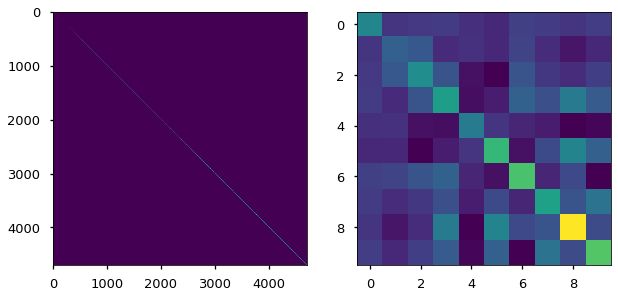

In [46]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].imshow(np.diag(rad_error))
ax[1].imshow(rad_error_red)
plt.show()

## GP Models

#### GP Regression

In [ ]:


kernel = GPy.kern.RBF(input_dim=X.shape[1], ARD=True)
normalize_y = True
optimizer = 'lbfgs'
max_iters = 1_000
X_variance = rad_error_red
verbose = 1
subsample = None
n_restarts = 10


gpr_model = GPRegressor(
    kernel=kernel,
    normalize_y=normalize_y,
    max_iters=max_iters,
    optimizer=optimizer,
    X_variance=X_variance,
    verbose=verbose,
    n_restarts=n_restarts
)

gpr_model.fit(X[:subsample], labels[:subsample, None]);

gpr_model.display_model()

#### Sparse GP Regression

In [72]:
import GPy

kernel = GPy.kern.RBF(input_dim=X.shape[1], ARD=True)
normalize_y = True
optimizer = 'scg'
max_iters = 1_000
X_variance = rad_error_red
verbose = 1
n_inducing = 300
subsample = None
n_restarts = 10


sgpr_model = SparseGPRegressor(
    kernel=kernel,
    normalize_y=normalize_y,
    max_iters=max_iters,
    optimizer=optimizer,
    X_variance=X_variance,
    verbose=verbose,
    n_restarts=n_restarts,
    n_inducing=n_inducing
)

sgpr_model.fit(X[:subsample], labels[:subsample, None]);

sgpr_model.display_model()

Running Scaled Conjugate Gradients Code:
  runtime   i      f              |g|        
    03s33  0006   8.367609e+03   7.187409e+05 
    12s19  0022   7.111358e+03   1.219158e+03 
    29s93  0054   7.094785e+03   9.363296e-01 
    33s27  0060   7.094727e+03   1.647209e-01 
    37s73  0068   7.094697e+03   2.286242e-04 
    42s18  0076   7.094694e+03   2.847666e-05 
Runtime:     42s18
Optimization status: converged - relative reduction in objective

Optimization restart 1/10, f = 7094.694339615421
Optimization restart 2/10, f = 7094.69268008835
Optimization restart 3/10, f = 7094.692681442437
Optimization restart 4/10, f = 7094.692690832902
Optimization restart 5/10, f = 7094.692713252111
Optimization restart 6/10, f = 7094.692846867608
Optimization restart 7/10, f = 7094.692678671764
Optimization restart 8/10, f = 7094.69273732367
Optimization restart 9/10, f = 7094.692677457881
Optimization restart 10/10, f = 7094.692862630754


sparse_gp.,value,constraints,priors
inducing inputs,"(300, 10)",,
rbf.variance,4.556361676131271e-09,+ve,
rbf.lengthscale,"(10,)",+ve,
Gaussian_noise.variance,1.0000059112254247,+ve,


#### Variational Sparse GP Regression

In [ ]:
import GPy

# GPR parameters
kernel      = GPy.kern.RBF(input_dim=X.shape[1], ARD=True)
normalize_y = True
optimizer   = 'scg'
max_iters   = 1_000
X_variance  = np.diag(rad_error_red)
verbose     = 1
n_inducing  = 300
subsample   = None
n_restarts  = 10


svgpr_model = UncertainSGPRegressor(
    kernel=kernel,
    normalize_y=normalize_y,
    max_iters=max_iters,
    optimizer=optimizer,
    X_variance=X_variance,
    verbose=verbose,
    n_restarts=n_restarts,
    n_inducing=n_inducing
)

svgpr_model.fit(X[:subsample], labels[:subsample, None]);

svgpr_model.display_model()

Running Scaled Conjugate Gradients Code:
  runtime   i      f              |g|        
 01m29s58  0005   8.367609e+03   7.187410e+05 
 05m40s00  0019   7.112346e+03   2.189884e+03 
 16m26s12  0055   7.094727e+03   9.363237e-01 
 18m31s84  0062   7.094705e+03   1.957255e-03 
 20m01s58  0067   7.094697e+03   2.751428e-02 
 21m49s17  0073   7.094694e+03   4.459700e-03 

##### w. Batch Processing

In [ ]:
import GPy

kernel = GPy.kern.RBF(input_dim=X.shape[1], ARD=True)
normalize_y = True
optimizer = 'scg'
max_iters = 1_000
X_variance = rad_error_red
verbose = 1
n_inducing = 300
subsample = None
n_restarts = 10
batch_size = 100


svgpr_model2 = UncertainSGPRegressor(
    kernel=kernel,
    normalize_y=normalize_y,
    max_iters=max_iters,
    optimizer=optimizer,
    X_variance=np.diag(X_variance),
    verbose=verbose,
    n_restarts=n_restarts,
    n_inducing=n_inducing,
    batch_size=batch_size
)

svgpr_model2.fit(X[:subsample], labels[:subsample, None]);

svgpr_model2.display_model()